**автоматический переводчик на основе рекуррентных нейросетей seq2seq**

кодируем слова word2vec

Евгений Борисов <borisov.e@solarl.ru>


----

## Библиотеки

In [1]:
import numpy as np
import re
import gzip

import pandas as pd
pd.options.display.max_colwidth = 200  


In [2]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Учебные данные

In [3]:
with gzip.open('../data/text/rus-eng/rus.txt.gz','rt',encoding='utf8') as f: 
    pair = pd.DataFrame([ p.split('\t') for p in f.read().split('\n') if p.strip() ])

In [4]:
# with open('../data/text/pairs.txt','rt',encoding='utf8') as f: 
#     pair = pd.DataFrame([ p.split('%%') for p in f.read().split('\n') if p.strip() ])

In [5]:
pair.columns=['Q','A']
pair['Q'] = pair['Q'].str.strip()
pair['A'] = pair['A'].str.strip()

In [6]:
ppr(pair)
pair.sample(9)

записей: 336 666


,Q,A
254275,The dog started running in circles.,Собака начала бегать кругами.
83935,Don't make me do that.,Не заставляйте меня это делать.
58503,Hold your positions.,Держите позиции!
298689,It took them two years to build the house.,На постройку дома у них ушло два года.
95220,Are you going to be OK?,Ты будешь в порядке?
327430,Women are not permitted to drive cars in Saudi Arabia.,В Саудовской Аравии женщинам запрещено водить автомобиль.
288029,I thought that that was kind of strange.,"Я подумал, что это как-то странно."
40708,Tom began praying.,Том начал молиться.
87736,I'm so glad I met you.,"Я так рад, что познакомился с тобой."


In [7]:
pair = pair.iloc[100000:110000]

## Чистим тексты

In [8]:
pair['Q_clean'] = pair['Q'].str.lower()
pair['Q_clean'] = pair['Q_clean'].str.replace(r'([,.?!])', r' \1 ')

pair['A_clean'] = pair['A'].str.lower()
pair['A_clean'] = pair['A_clean'].str.replace(r'([,.?!])', r' \1 ')

# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'(\W)', ' \1 ', s))
# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'\W', ' ', s))
# pair['A_clean'] = pair['A_clean'].apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s)) 

In [9]:
# добавляем "служебные" слова - начало и конец последовательности
pair['Q_clean'] = pair['Q_clean'].str.split() + ['<START>']
# pair['Q_clean'] = ['<START>'] + pair['Q_clean'].str.split() + ['<EOS>']
pair['A_clean'] = ['<GO>'] + pair['A_clean'].str.split() + ['<EOS>']

In [10]:
pair[['Q_clean','A_clean']].sample(9)

,Q_clean,A_clean
108920,"[do, you, have, a, cellphone, ?, <START>]","[<GO>, у, тебя, есть, мобильный, телефон, ?, <EOS>]"
105401,"[tom, was, at, the, meeting, ., <START>]","[<GO>, том, был, на, встрече, ., <EOS>]"
103887,"[tom, has, a, lot, of, debts, ., <START>]","[<GO>, у, тома, много, долгов, ., <EOS>]"
100939,"[it's, a, beautiful, sword, ., <START>]","[<GO>, это, красивый, меч, ., <EOS>]"
102962,"[they're, all, against, me, ., <START>]","[<GO>, они, все, против, меня, ., <EOS>]"
100911,"[it, was, very, mysterious, ., <START>]","[<GO>, это, было, очень, таинственно, ., <EOS>]"
102545,"[the, dog, is, still, alive, ., <START>]","[<GO>, собака, еще, жива, ., <EOS>]"
109082,"[do, you, think, tom, saw, me, ?, <START>]","[<GO>, думаете, ,, том, меня, видел, ?, <EOS>]"
104689,"[tom, met, mary, at, school, ., <START>]","[<GO>, том, познакомился, с, мэри, в, школе, ., <EOS>]"


---

In [11]:
# считаем количество слов
pair['lenQ'] = pair['Q_clean'].str.len()
pair['lenA'] = pair['A_clean'].str.len()
pair.describe()

,lenQ,lenA
count,10000.000000,10000.000000
mean,6.722400,7.270400
std,0.737965,1.175084
min,4.000000,4.000000
25%,6.000000,6.000000
50%,7.000000,7.000000
75%,7.000000,8.000000
max,9.000000,13.000000


In [12]:
# определяем максимальную длинну последовательности
pair['lenQ'].quantile(0.95),  pair['lenA'].quantile(0.95)

(8.0, 9.0)

In [13]:
sent_len_a_max = pair['lenA'].max()
sent_len_q_max = pair['lenQ'].max()

In [14]:
# выстраиваем входные последовательности в обратном порядке
# и выравниваем длинну последовательностей,
# дополняем короткие словом "служебным" словом,
pad = ['<PAD>']*sent_len_q_max
pair['Q_clean'] = pair['Q_clean'].apply( lambda t: pad[len(t):] + list(reversed(t)) )
# pair['Q_clean'] = pair['Q_clean'].apply( lambda t: pad[len(t):] + t )
# pair['Q_clean'] = pair['Q_clean'].apply( lambda t: t + pad[len(t):] )

pad = ['<PAD>']*sent_len_a_max
pair['A_clean'] = pair['A_clean'].apply( lambda t: t + pad[len(t):] )

In [15]:
pair[['Q_clean','A_clean']].sample(9)

,Q_clean,A_clean
107903,"[<PAD>, <PAD>, <START>, ., here, it, like, won't, you]","[<GO>, тебе, тут, не, понравится, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
108882,"[<PAD>, <START>, ?, actor, an, like, look, i, do]","[<GO>, я, похож, на, актёра, ?, <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
107651,"[<PAD>, <PAD>, <START>, ., pale, little, a, look, you]","[<GO>, ты, выглядишь, слегка, бледным, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
108766,"[<PAD>, <PAD>, <START>, ?, police, the, call, you, did]","[<GO>, ты, вызвала, полицию, ?, <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
105761,"[<PAD>, <START>, ., that, like, it, do, to, try]","[<GO>, попробуйте, сделать, это, вот, так, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
104496,"[<PAD>, <PAD>, <PAD>, <START>, ., careful, very, isn't, tom]","[<GO>, том, не, очень, осторожен, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
100977,"[<PAD>, <PAD>, <PAD>, <PAD>, <START>, ., impossible, almost, it's]","[<GO>, это, почти, невозможно, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"
104993,"[<PAD>, <PAD>, <START>, ., lying, is, mary, says, tom]","[<GO>, том, говорит, ,, что, мэри, лжёт, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>]"
107472,"[<PAD>, <START>, ., me, to, next, sit, can, you]","[<GO>, можешь, сесть, рядом, со, мной, ., <EOS>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>]"


## Кодируем тексты

In [16]:
# data = pair['Q_clean'].values.tolist() + pair['A_clean'].values.tolist()

In [17]:
%%time

from gensim.models.word2vec import Word2Vec

w2v_size = 256

w2v_q = Word2Vec( pair['Q_clean'].values.tolist(), min_count=1, size=w2v_size, window=4, workers=4)
w2v_a = Word2Vec( pair['A_clean'].values.tolist(), min_count=1, size=w2v_size, window=4, workers=4)

CPU times: user 1.17 s, sys: 34 ms, total: 1.2 s
Wall time: 797 ms


In [18]:
# w2v_q_vocab = sorted([w for w in w2v_q.wv.vocab])
# ppr(w2v_q_vocab)

# w2v_a_vocab = sorted([w for w in w2v_a.wv.vocab])
# ppr(w2v_a_vocab)

In [19]:
# ii = np.random.permutation(len(w2v_q_vocab))[:10]
# for i in ii:
#     w = w2v_q_vocab[i]
#     ww = [ v[0] for v in w2v_q.wv.most_similar(w, topn=5) ]
#     print( w,':',ww )

In [20]:
# ii = np.random.permutation(len(w2v_a_vocab))[:10]
# for i in ii:
#     w = w2v_a_vocab[i]
#     ww = [ v[0] for v in w2v_a.wv.most_similar(w, topn=5) ]
#     print( w,':',ww )

---

In [21]:
# c = w2v_a.wv['<GO>']
# w2v_a.wv.similar_by_vector(c)[0][0] 
# c.min(), c.max()

---

In [22]:
pair['Q_code'] = pair['Q_clean'].apply(lambda t: [ w2v_q.wv.get_vector(w) for w in t ] )
pair['A_code'] = pair['A_clean'].apply(lambda t: [ w2v_a.wv.get_vector(w) for w in t ] )

In [23]:
# pair[['Q_code','A_code']].sample(3)


-----

In [24]:
# ppr(pair)

In [25]:
# pair = pair.sample(1000)
# pair = pair.sample(283800)
# pair = pair.sample(600)

In [26]:
encoder_input_data = np.stack( pair['Q_code'].values ).astype(np.float32)

decoder_input_data = np.stack( pair['A_code'].values )[:,:-1,:].astype(np.float32)
decoder_target_data = np.stack( pair['A_code'].values )[:,1:,:].astype(np.float32)

encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 9, 256), (10000, 12, 256), (10000, 12, 256))

In [27]:
# np.abs(encoder_input_data).max(), np.abs(decoder_input_data).max()

## Строим нейросеть

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [29]:
latent_dim = 256  # размер сети

In [30]:
encoder_inputs = Input(shape=(None, w2v_size))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
from keras import backend as K
def custom_activation(x):  return (K.tanh(x)*2.1)
# model.add(Dense(32 , activation=custom_activation))

Using TensorFlow backend.


In [32]:
decoder_inputs = Input(shape=(None, w2v_size))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

# decoder_dense = Dense(w2v_size)
# decoder_dense = Dense(w2v_size, activation='softmax')
decoder_dense = Dense(w2v_size, activation='tanh')
# decoder_dense = Dense(w2v_size, activation='sigmoid')
# decoder_dense = Dense(w2v_size, activation=custom_activation)

decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 256)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 256)    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 525312      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  525312      input_2[0][0]                    
                                                                 lstm[0][1]                       
          

In [35]:
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(loss='mse', optimizer='rmsprop')
# model.compile(loss='mse', optimizer='adam')
# model.compile(loss='mse', optimizer='sgd')

Instructions for updating:
Use tf.cast instead.


In [47]:
%%time 

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=100,
          epochs=20,
          validation_split=0.1
        ) 

Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 13s 1ms/sample - loss: 0.0048 - val_loss: 0.0053
Epoch 2/20
9000/9000 [==============================] - 12s 1ms/sample - loss: 0.0047 - val_loss: 0.0055
Epoch 3/20
9000/9000 [==============================] - 13s 1ms/sample - loss: 0.0047 - val_loss: 0.0058
Epoch 4/20
9000/9000 [==============================] - 12s 1ms/sample - loss: 0.0046 - val_loss: 0.0054
Epoch 5/20
9000/9000 [==============================] - 12s 1ms/sample - loss: 0.0046 - val_loss: 0.0055
Epoch 6/20
9000/9000 [==============================] - 13s 1ms/sample - loss: 0.0045 - val_loss: 0.0056
Epoch 7/20
9000/9000 [==============================] - 12s 1ms/sample - loss: 0.0044 - val_loss: 0.0057
Epoch 8/20
9000/9000 [==============================] - 13s 1ms/sample - loss: 0.0044 - val_loss: 0.0057
Epoch 9/20
9000/9000 [==============================] - 12s 1ms/sample - loss: 0.0043 - val_loss: 0.0056
Epoch 1

## Проверяем результат

In [37]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [38]:
def decode_sequence(input_seq):
    # генерируем состояние энкодера
    states_value = encoder_model.predict(input_seq)

    # вход декодера - последовательность из одного слова GO
    output_w2v = w2v_a.wv['<GO>'].reshape([1,1,w2v_size])

    # выходная последовательность
    decoded_sentence = []
    
    for i in range(sent_len_a_max): 
        output_w2v, h, c = decoder_model.predict([output_w2v] + states_value)

        # декодируем cлово
        cc = output_w2v.reshape(w2v_size)
        w = w2v_a.wv.similar_by_vector(cc)[0][0] 
        
        # если очередное слово это EOS
        if(w=='<EOS>'): break # то завершаем работу

        decoded_sentence.append(w)
       
        states_value = [h,c] # обновляем состояние сети

    return ' '.join(decoded_sentence)

In [46]:
ii = np.random.permutation(len(encoder_input_data))[:10]
for seq_index in ii:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print( pair.iloc[seq_index]['Q'],' -> ', decoded_sentence )

/usr/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Who asked Tom to leave?  ->  правда тот мне хотите явно ! врач <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Tom knows who did that.  ->  ты знал мне пожалуйста мне план !
You're easy to talk to.  ->  вы должен быть так ? врач <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Do you want me to do it?  ->  вы — хотите хотите быть ! томе встретиться сделать порядке <PAD> <PAD> <PAD>
He leads an active life.  ->  мы наше она машине .
Are you with the police?  ->  мы никому бы ? врач сделать сделать порядке <PAD> <PAD> <PAD> <PAD> <PAD>
This decision is final.  ->  мы пришёл всё ?
Don't be so sentimental.  ->  мы вам бы . согласился порядке заняты порядке <PAD> <PAD> <PAD> <PAD> <PAD>
You're as tall as I am.  ->  ты знал , хотите хочешь тому увидеть идти сделать порядке <PAD> <PAD> <PAD>
The water was lukewarm.  ->  мы и был ?


----

In [40]:
import matplotlib.pyplot as plt

In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

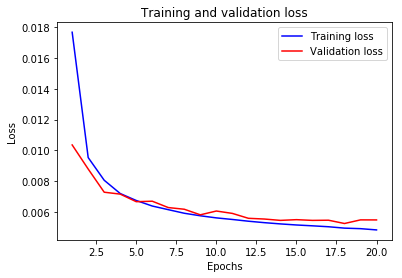

In [42]:
# acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
# plt.clf()   # clear figure
# acc_values = history_dict['acc']
# val_acc_values = history_dict['val_acc']

# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

---

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

In [45]:
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

if tf.test.is_built_with_cuda():
    print('GPU devices:\n  ',
        [ [x.name, x.physical_device_desc] 
          for x in device_lib.list_local_devices() 
          if x.device_type == 'GPU' ]
    )
    print('default GPU device:', tf.test.gpu_device_name() )

else:
    print('no GPU device found')
    

tensorflow: 1.13.1
keras: 2.2.4-tf
GPU devices:
   [['/device:GPU:0', 'device: 0, name: GeForce GT 730, pci bus id: 0000:01:00.0, compute capability: 3.5']]
default GPU device: /device:GPU:0
